In [2]:
using Random, Gadfly, Optim, Distributions, Distances, LinearAlgebra, ForwardDiff, Cairo

include("iGMRF.jl");
include("dataGen.jl");
include("approxFramework.jl");

In [13]:
# Seed
Random.seed!(400)
# Dimensions de la grille
m₁ = 10;
m₂ = 10;
# Nb total de cellules
m = m₁ * m₂;
# Matrice de structure
κᵤ = 100.0;
F = iGMRF(m₁, m₂, κᵤ);
# Grille cible
grid_target = generateTargetGrid(F);
grid_target[:, :, 1] = grid_target[:, :, 1] .+ 10;
# Génération de données
nobs = 100;
Y = generateData(grid_target, nobs);

# Mode de la forme fonctionnelle

In [4]:
α = Optim.minimizer(findMode(θ -> densityTarget(θ, F=F, Y=Y), [1, fill(0.0, m)...]))

10-element Vector{Float64}:
  5.925536735131695
 10.009665229688315
 10.003219857293212
  9.988501837292164
 10.01184931469106
  9.994964047002501
  9.989323934742988
  9.991383080122967
  9.981799145386129
  9.984572290417047

# Tracé de $\kappa_u$ après avoir standardisé la posteriori

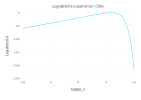

In [5]:
npoints = 10000; # Nombre de points sur lesquels évaluer la pdf
x = range(-10, 10, npoints);

# Mode de la posteriori
mode = findMode(θ -> functionalFormPosterior(θ, F=F, Y=Y), [1, fill(0.0, m)...]);
α = Optim.minimizer(mode);
gap = Optim.minimum(mode);

analysisSpace = zeros(m+1, npoints);
for j = 1:npoints
    analysisSpace[:, j] = [x[j], α[2:end]...];
end

simPosterior = vec(mapslices(x -> densityTarget(x, gap, F=F, Y=Y), analysisSpace, dims=1));

p = plot(
    layer(x=x, y=simPosterior, Geom.line),
    Theme(background_color="white"),
    Guide.title("Log-densité a posteriori cible"),
    Guide.xlabel("kappa_u"),
    Guide.ylabel("Log-densité"),
)

# Tracé d'une log-normale

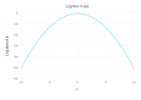

In [4]:
npoints = 10000; # Nombre de points sur lesquels évaluer la pdf
x = range(-10, 10, npoints);

p = plot(
    layer(x=x, y=logpdf.(Normal(0, 1), x), Geom.line),
    Theme(background_color="white"),
    Guide.title("Log-Normale"),
    Guide.xlabel("x"),
    Guide.ylabel("Log-densité"),
)

# Tracé de l'approximation de Fisher

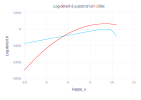

In [14]:
npoints = 10000; # Nombre de points sur lesquels évaluer la pdf
x = range(-10, 11, npoints);

# Mode de la posteriori
mode = findMode(θ -> functionalFormPosterior(θ, F=F, Y=Y), [1, fill(0.0, m)...]);
α = Optim.minimizer(mode);
gap = Optim.minimum(mode);

# Variance de Fisher
Fvar = inv(computeFisherInformation(θ -> densityTarget(θ, gap, F=F, Y=Y), α));
Σ = round.(Fvar .* 3, digits=5)

# Approximation de Fisher
logDensityApprox(x::DenseVector) = logpdf(MvNormal(α, Σ), x);

# Support d'évaluation des deux distributions
analysisSpace = zeros(m+1, npoints);
for j = 1:npoints
    analysisSpace[:, j] = [x[j], α[2:end]...];
end

simPosterior = vec(mapslices(x -> densityTarget(x, gap, F=F, Y=Y), analysisSpace, dims=1));
simApprox = vec(mapslices(x -> logDensityApprox(x), analysisSpace, dims=1));

p = plot(
    layer(x=x, y=simPosterior, Geom.line),
    layer(x=x, y=simApprox, Geom.line, Theme(default_color="red")),
    Theme(background_color="white"),
    Guide.title("Log-densité a posteriori cible"),
    Guide.xlabel("kappa_u"),
    Guide.ylabel("Log-densité"),
)